<a href="https://colab.research.google.com/github/adi1102/LearnGit/blob/master/Assignments/Assignment_09/Assignment_09_Lab_10_mAP_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)

[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)

# **Assignment 09:** Object detection

In this assignment we will perform single and multi class object detection.

For this, you will use the [Caltech101 object detection dataset](https://data.caltech.edu/records/20086) [[Paper]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1597116).

In the provided source code, we use VGG16 as backbone for single class object detection. Now, change the backbone for another pre-trained model.

- Change **VGG16** for another **pre-trained** model. For this, modify the file `models.py`.
- Run your experiments only for **single class object detection**.
- **Comment** on your results.
- Feel free to **change** the **class** of interest in your experiments.

**Description:**

Pictures of objects belonging to `101` categories. About `40 to 800` images per category. Most categories have about `50` images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc'Aurelio Ranzato. The size of each image is roughly `300 x 200` pixels. Outlines of each object in these pictures are included under the `Annotations.tar`.


## **Mount Google Drive to Google Colab**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Change **this path** to the **path of a folder** in your Google Drive to storage the files associated to this session (trained model, figures for visualization, etc.)

In [3]:
# %cd drive/MyDrive/PATH/TO/YOUR/FOLDER
%cd drive/MyDrive/Deep_Learning/Assignment_09/

/content/drive/MyDrive/Deep_Learning/Assignment_09


## **Load packages and data**

In [9]:
# Management of files
import os
from os import makedirs, listdir
from os.path import exists, join, isdir


# Tensorflow and Keras
from tensorflow.keras.callbacks import ModelCheckpoint, \
                                       EarlyStopping, \
                                       TensorBoard
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# Visualization
import matplotlib.pyplot as plt

# Working with dataframes
import pandas as pd

# Working with arrays
import numpy as np

# Measuring processing time
import time

import imagesize

# External files with functions to load the dataset,
# create a CNN model, and a data generator.
from importlib import reload
import datasets
import models
#import models_mod
import data_generator
import utils
#import utils_mod
# Useful to reload modified external files without need
# of restarting the kernel. Just run again this cell.
reload(datasets)
reload(models)
#reload(models_mod)
reload(data_generator)
reload(utils)
#reload(utils_mod)

from datasets import *
from models import *
#from models_mod import *
from data_generator import *
from utils import *
#from utils_mod import *

**Variables**

In [10]:
PROJECT_DIR = "." # os.getcwd()
DATA_DIR = join(PROJECT_DIR, "caltech-101")

IMAGES_PATH = join(DATA_DIR, "101_ObjectCategories")
ANNOTS_PATH = join(DATA_DIR,"Annotations")

CVS_PATH = join(DATA_DIR, "annotations_as_csv")
makedirs(CVS_PATH,exist_ok = True)

SINGLE_CLASS_DIR = join(PROJECT_DIR, "single_class")
MULTI_CLASS_DIR = join(PROJECT_DIR, "multi_class")

makedirs(SINGLE_CLASS_DIR, exist_ok = True)
makedirs(MULTI_CLASS_DIR, exist_ok = True)

SEED = 42

### **Downloading the dataset**

In [ ]:
download_caltech101(PROJECT_DIR)

### **Pre-processing annotations**

Since the annotaions are in `.mat` format, let's convert them to `.csv` format.

Check whether images folders' name are consistent with annotations.

In [11]:
class_names = set(listdir(IMAGES_PATH))
annotations_name=[d for d in listdir(ANNOTS_PATH) if isdir(join(ANNOTS_PATH, d))]
annotations_name = set(annotations_name)
print(class_names - annotations_name, annotations_name - class_names)

{'Faces_easy', 'Motorbikes', 'airplanes', 'BACKGROUND_Google', 'Faces'} {'Faces_3', 'Faces_2', 'Airplanes_Side_2', 'Motorbikes_16'}


As there are inconsistencies, it is necessary to save the annotations in a way that they exactly correspond to the images folders.

In [ ]:
for _, directories, _ in os.walk(ANNOTS_PATH):
  for dir in directories:
    class_name = dir
    class_name_new = class_name
    if class_name == 'Airplanes_Side_2':
      class_name_new = 'airplanes'
    if class_name == 'Faces_3':
      class_name_new = 'Faces_easy'
    if class_name == 'Faces_2':
      class_name_new = 'Faces'
    if class_name == 'Motorbikes_16':
      class_name_new = 'Motorbikes'

    annotations_csv_file = convert_mat2csv(class_name=class_name,
                                           class_name_new=class_name_new,
                                           ANNOTS_PATH=ANNOTS_PATH,
                                           ANNOTS_PATH_for_csv=CVS_PATH)

[INFO] annotations of 34 images in wild_cat category read
[INFO] writing annotations of 34 images in wild_cat category to ./caltech-101/annotations_as_csv/wild_cat.csv ... finished
[INFO] annotations of 56 images in windsor_chair category read
[INFO] writing annotations of 56 images in windsor_chair category to ./caltech-101/annotations_as_csv/windsor_chair.csv ... finished
[INFO] annotations of 59 images in wheelchair category read
[INFO] writing annotations of 59 images in wheelchair category to ./caltech-101/annotations_as_csv/wheelchair.csv ... finished
[INFO] annotations of 239 images in watch category read
[INFO] writing annotations of 239 images in watch category to ./caltech-101/annotations_as_csv/watch.csv ... finished
[INFO] annotations of 39 images in wrench category read
[INFO] writing annotations of 39 images in wrench category to ./caltech-101/annotations_as_csv/wrench.csv ... finished
[INFO] annotations of 86 images in trilobite category read
[INFO] writing annotations o

## **Single class object detection**

First, we will work with a single class: `airplanes`



In [13]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100

class_name = 'airplanes'

### **Dataset**

#### **Reading the dataset**

For later use, let's save the image paths and bounding box coordinates.

In [14]:
DATA_TARGETS_NPY = join(SINGLE_CLASS_DIR, "data_targets.npy")

data_list, targets = create_data_targets(IMAGES_PATH,
                                         CVS_PATH,
                                         class_name,
                                         DATA_TARGETS_NPY)

# For sanity check, we print out the number of images and bounding boxes
print (f'Images:{len(data_list)}')
print (f'Bounding Boxes: {targets.shape}')

Processing time:5.9e+02 seconds
Images:800
Bounding Boxes: (800, 4)


#### **Train, Val, and Test splits**

Let's split the dataset to create the train, validation and test sets.

In [15]:
splits = train_val_test_split(data_list=data_list,
                              targets=targets,
                              seed=SEED)

# As a sanity check, we print out the number of images
print ('All samples :', len(data_list))
print ('Training    :', len(splits["x_train"]))
print ('Validation  :', len(splits["x_val"]))
print ('Test        :', len(splits["x_test"]))

All samples : 800
Training    : 480
Validation  : 160
Test        : 160


#### **Loading images**

As there are only 800 images, we can load all images in memory.

_This process can take some minutes (~7 mins. approx.)._

In [16]:
train_images = load_images(path_images=splits["x_train"],
                           target_size=TARGET_SIZE)
val_images = load_images(path_images=splits["x_val"],
                         target_size=TARGET_SIZE)
test_images = load_images(path_images=splits["x_test"],
                          target_size=TARGET_SIZE)

#As a sanity check, we print out the size of the training and validation data.
print('Training data shape :', train_images.shape)
print('Validation data shape :', val_images.shape)
print('Test data shape :', test_images.shape)

Training data shape : (480, 224, 224, 3)
Validation data shape : (160, 224, 224, 3)
Test data shape : (160, 224, 224, 3)


#### **Visualization**

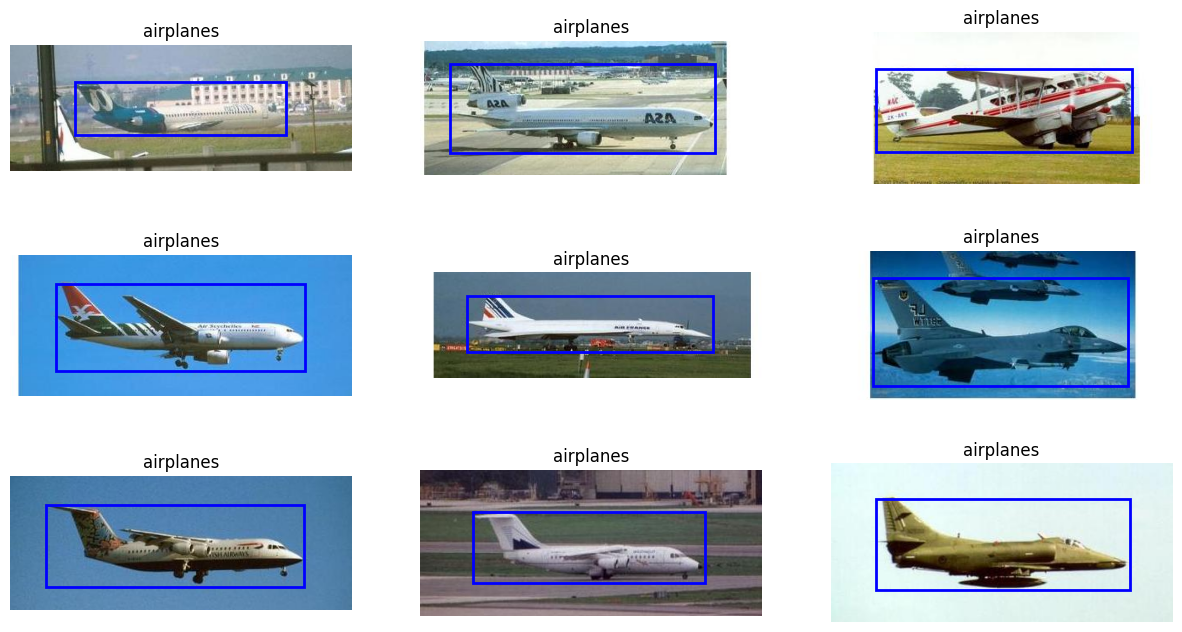

In [17]:
show_samples(img_path=splits["x_train"],
             targets=splits["y_train"],
             class_name=class_name,
             seed=SEED)

### **Model**

We can perform **object detection** using a **pre-trained** model as *backbone*.

In this case, we will use **VGG16** as *backbone*. Then, we have to add **fully connected** layers as *HEAD* of the model.

In [20]:
#single_class_model = get_vgg_regression(input_shape=(TARGET_SIZE[0],TARGET_SIZE[0],3), "vgg16")
single_class_model = get_vgg_regression(input_shape=(TARGET_SIZE[0], TARGET_SIZE[0], 3), model="vgg16")


single_class_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

#### **Callbacks**

In [21]:
# Checkpoints
autosave = ModelCheckpoint(join(SINGLE_CLASS_DIR,"vgg16_regression.h5"),
                           mode="min",
                           save_best_only=True,
                           monitor="val_loss",
                           verbose=1)

# Early stopping
early_stop = EarlyStopping(patience=20,
                           verbose=1,
                           mode="min",
                           monitor="val_loss")

# Tensorboard
logdir = join(PROJECT_DIR, "logs_single_class")
tb = TensorBoard(logdir, histogram_freq=1)

cbks = [autosave, early_stop, tb]

#### **Training**

In [22]:
history = single_class_model.fit(train_images,
                                 splits["y_train"],
                                 validation_data=(val_images,
                                                  splits["y_val"]),
                                 batch_size=BATCH_SIZE,
                                 epochs=EPOCHS,
                                 callbacks=cbks)

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.0118
Epoch 1: val_loss improved from inf to 0.00222, saving model to ./single_class/vgg16_regression.h5
30/30 [==============================] - 19s 250ms/step - loss: 0.0118 - val_loss: 0.0022
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.0010
Epoch 2: val_loss improved from 0.00222 to 0.00167, saving model to ./single_class/vgg16_regression.h5
30/30 [==============================] - 7s 248ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 6.8149e-04
Epoch 3: val_loss improved from 0.00167 to 0.00160, saving model to ./single_class/vgg16_regression.h5
30/30 [==============================] - 7s 224ms/step - loss: 6.8149e-04 - val_loss: 0.0016
Epoch 4/100
30/30 [==============================] - ETA: 0s - loss: 5.3394e-04
Epoch 4: val_loss improved from 0.00160 to 0.00154, saving model to ./single_class/vgg16_regression.h5
30/30 [=

#### **TensorBoard Dev**

In [23]:
!tensorboard dev upload --logdir logs_single_class --name "Single class object detection" --one_shot

2023-07-29 22:36:39.210885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs_single_class

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   BPVT-YKPM



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

### **Results**

1/1 [==============================] - 2s 2s/step


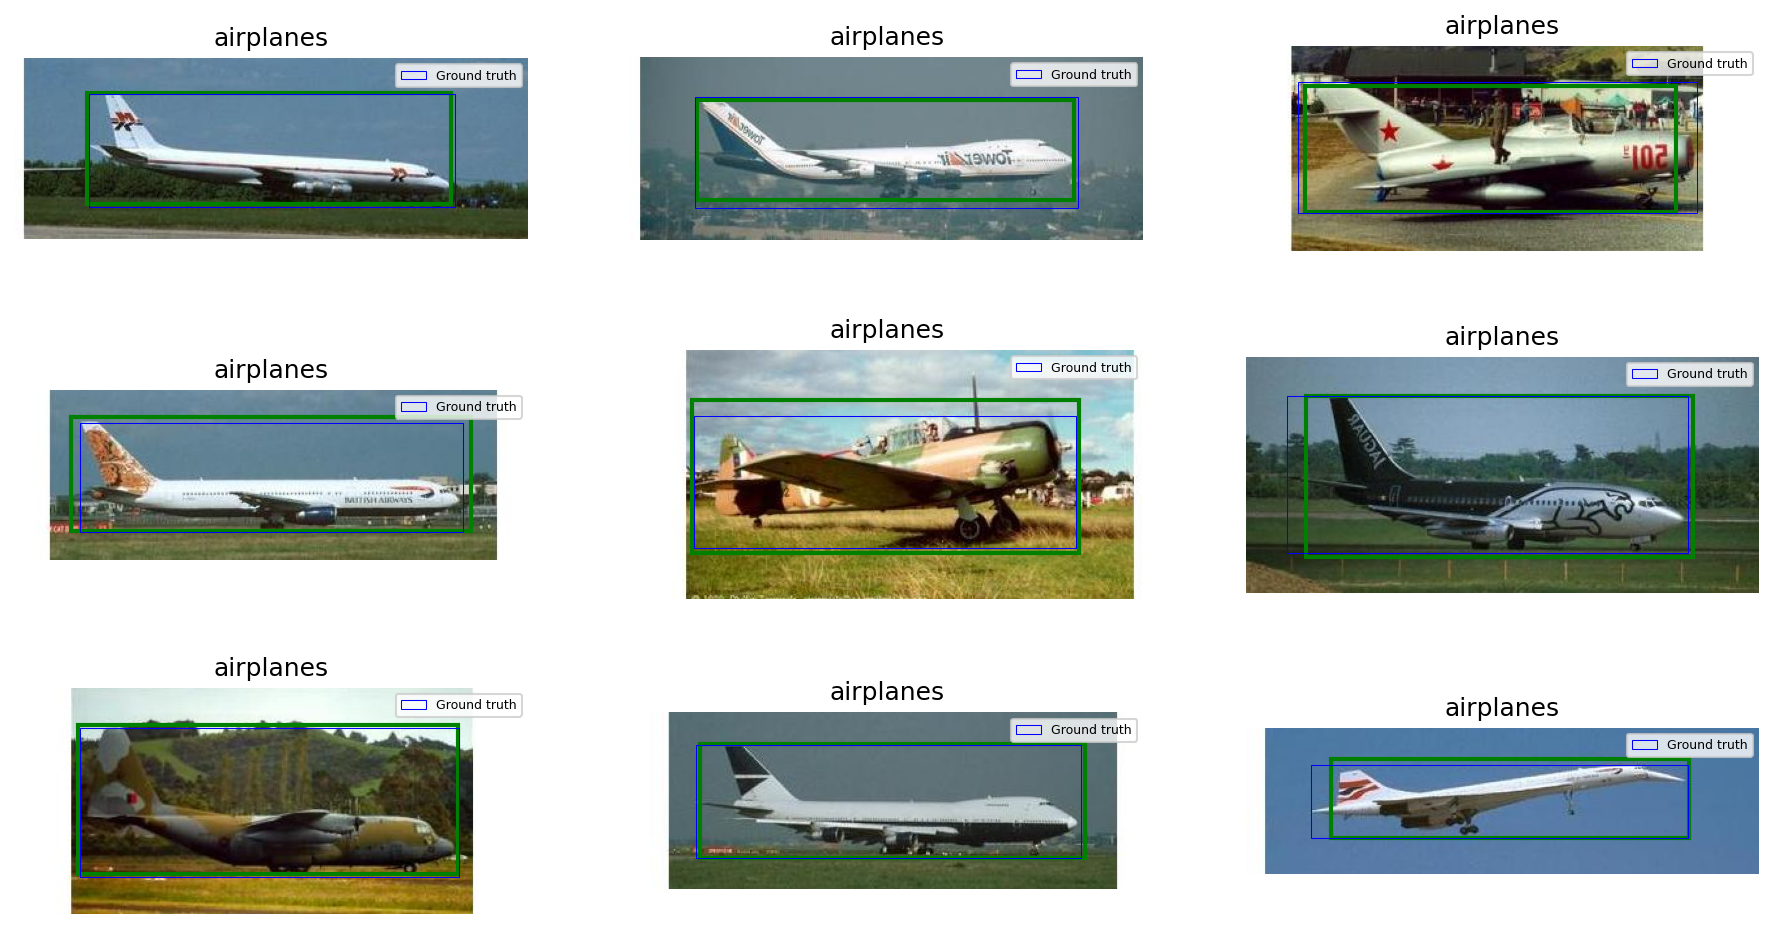

In [24]:
show_results(img_npy=test_images,
             img_paths=splits["x_test"],
             targets=splits["y_test"],
             class_name=class_name,
             model=single_class_model,
             seed=SEED)

In [25]:
# Evaluate the model on the test dataset
results = single_class_model.evaluate(test_images, splits["y_test"])

# Print the evaluation results
print("Loss: {:.4f}".format(results))

5/5 [==============================] - 5s 123ms/step - loss: 5.7904e-04
Loss: 0.0006


In [27]:
import utils_mod
from utils_mod import *

In [28]:
calculate_mIoU(img_npy=test_images,
             targets=splits["y_test"],
             model=single_class_model,iou_threshold=0.85)

5/5 [==============================] - 1s 127ms/step


0.90553474

In [38]:
class_name = 'Faces'

In [39]:
DATA_TARGETS_NPY = join(SINGLE_CLASS_DIR, "data_targets.npy")

data_list, targets = create_data_targets(IMAGES_PATH,
                                         CVS_PATH,
                                         class_name,
                                         DATA_TARGETS_NPY)

# For sanity check, we print out the number of images and bounding boxes
print (f'Images:{len(data_list)}')
print (f'Bounding Boxes: {targets.shape}')

Processing time:3e+02 seconds
Images:435
Bounding Boxes: (435, 4)


In [40]:
splits = train_val_test_split(data_list=data_list,
                              targets=targets,
                              seed=SEED)

# As a sanity check, we print out the number of images
print ('All samples :', len(data_list))
print ('Training    :', len(splits["x_train"]))
print ('Validation  :', len(splits["x_val"]))
print ('Test        :', len(splits["x_test"]))

All samples : 435
Training    : 261
Validation  : 87
Test        : 87


In [41]:
train_images = load_images(path_images=splits["x_train"],
                           target_size=TARGET_SIZE)
val_images = load_images(path_images=splits["x_val"],
                         target_size=TARGET_SIZE)
test_images = load_images(path_images=splits["x_test"],
                          target_size=TARGET_SIZE)

#As a sanity check, we print out the size of the training and validation data.
print('Training data shape :', train_images.shape)
print('Validation data shape :', val_images.shape)
print('Test data shape :', test_images.shape)

Training data shape : (261, 224, 224, 3)
Validation data shape : (87, 224, 224, 3)
Test data shape : (87, 224, 224, 3)


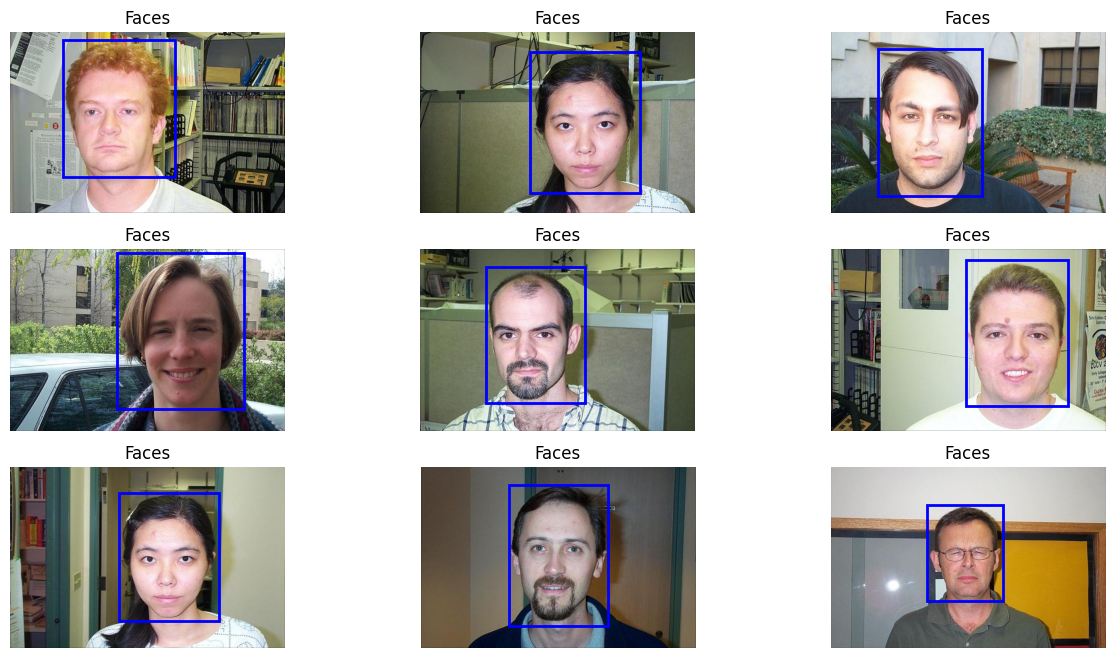

In [42]:
show_samples(img_path=splits["x_train"],
             targets=splits["y_train"],
             class_name=class_name,
             seed=SEED)

In [43]:
# Checkpoints
autosave = ModelCheckpoint(join(SINGLE_CLASS_DIR,"vgg16_faces_regression.h5"),
                           mode="min",
                           save_best_only=True,
                           monitor="val_loss",
                           verbose=1)

# Early stopping
early_stop = EarlyStopping(patience=20,
                           verbose=1,
                           mode="min",
                           monitor="val_loss")

# Tensorboard
logdir = join(PROJECT_DIR, "logs_faces_16_single_class")
tb = TensorBoard(logdir, histogram_freq=1)

cbks = [autosave, early_stop, tb]

In [44]:
history = single_class_model.fit(train_images,
                                 splits["y_train"],
                                 validation_data=(val_images,
                                                  splits["y_val"]),
                                 batch_size=BATCH_SIZE,
                                 epochs=EPOCHS,
                                 callbacks=cbks)

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.0050
Epoch 1: val_loss improved from inf to 0.00152, saving model to ./single_class/vgg16_faces_regression.h5
17/17 [==============================] - 10s 549ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 2/100
16/17 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 2: val_loss improved from 0.00152 to 0.00132, saving model to ./single_class/vgg16_faces_regression.h5
17/17 [==============================] - 7s 410ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/100
16/17 [===========================>..] - ETA: 0s - loss: 0.0010
Epoch 3: val_loss improved from 0.00132 to 0.00125, saving model to ./single_class/vgg16_faces_regression.h5
17/17 [==============================] - 5s 334ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/100
16/17 [===========================>..] - ETA: 0s - loss: 7.2431e-04
Epoch 4: val_loss improved from 0.00125 to 0.00103, saving model to ./single_class/vgg16_faces_regres

In [45]:
!tensorboard dev upload --logdir logs_faces_16_single_class --name "Single class object detection" --one_shot

2023-07-29 23:03:20.822307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/xv8deRE0SKOMzNY4NYu7eA/

[2023-07-29T23:03:23] Started scanning logdir.
E0729 23:03:31.566997 132804873048704 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2023-07-29T23:03:37] Total uploaded: 546 scalars, 6188 tensors (4.3 MB), 1 binary objects (101.0 kB)
Total skipped: 1 binary objects (95.2 kB)
[2023-07-29T23:03:37] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/xv8deRE0SKOMzNY4NYu7eA/


1/1 [==============================] - 0s 27ms/step


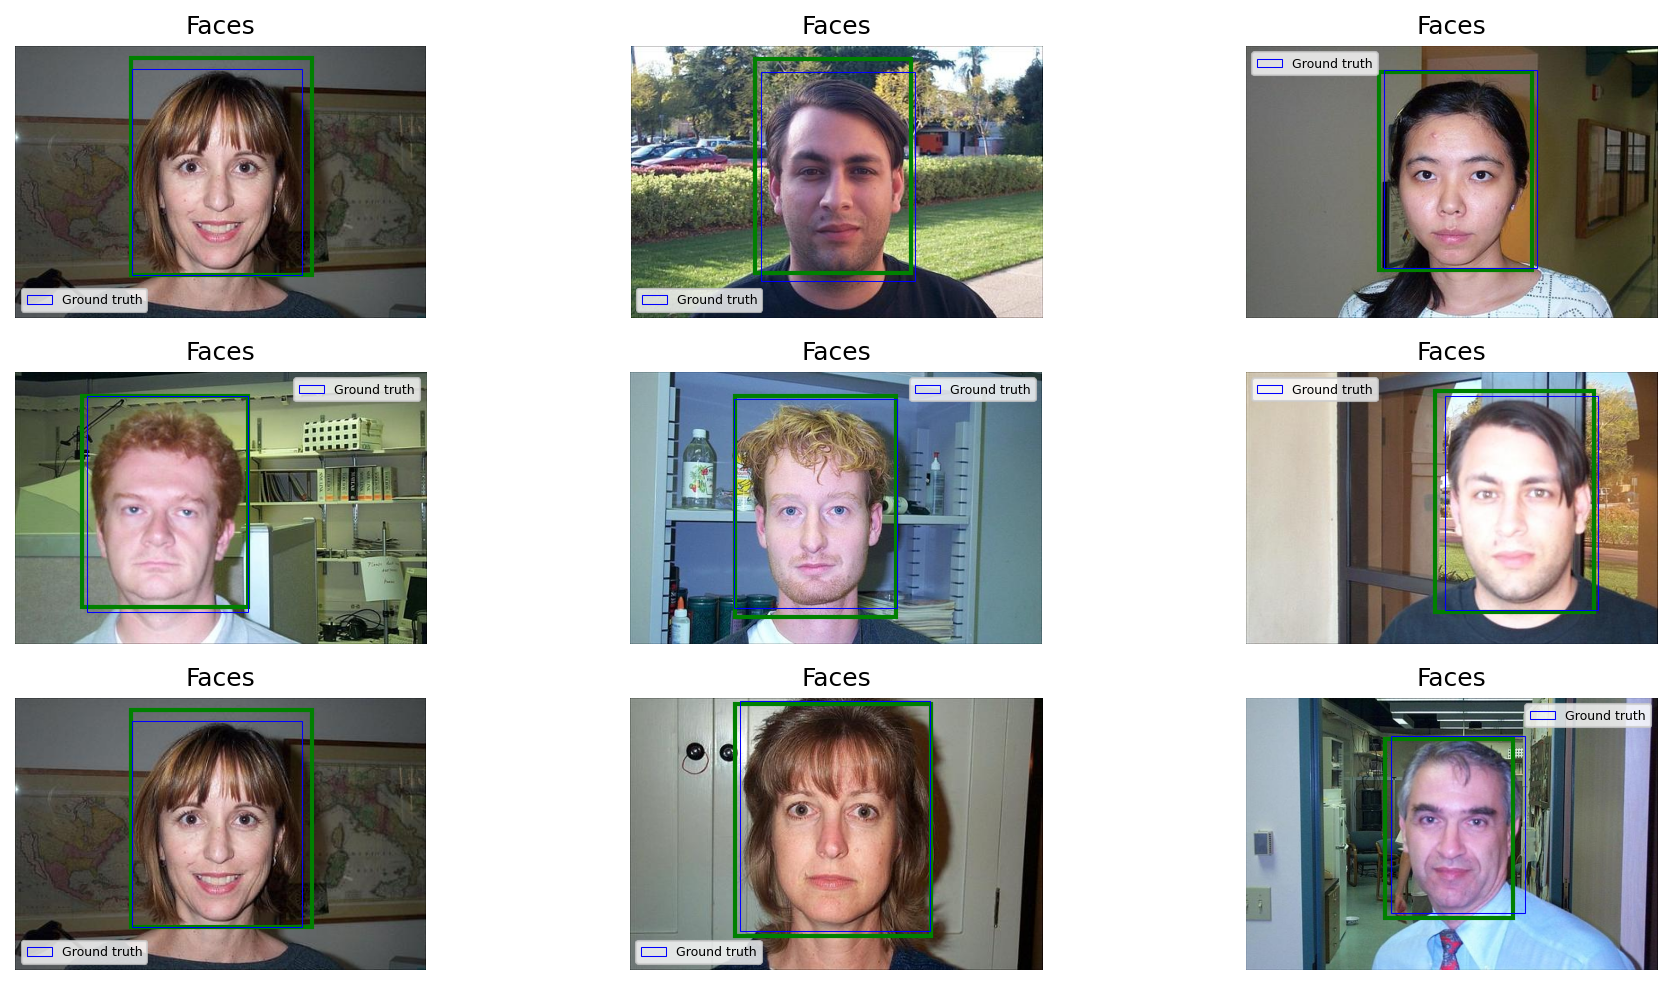

In [46]:
show_results(img_npy=test_images,
             img_paths=splits["x_test"],
             targets=splits["y_test"],
             class_name=class_name,
             model=single_class_model,
             seed=SEED)

In [47]:
# Evaluate the model on the test dataset
results = single_class_model.evaluate(test_images, splits["y_test"])

# Print the evaluation results
print("Loss: {:.4f}".format(results))

3/3 [==============================] - 4s 2s/step - loss: 4.5548e-04
Loss: 0.0005


In [48]:
calculate_mIoU(img_npy=test_images,
             targets=splits["y_test"],
             model=single_class_model,iou_threshold=0.85)

3/3 [==============================] - 0s 150ms/step


0.88842255

# **Lab 10:** Object detection

## **Multi class object deteection**

**This is not part of the Assignment 09. We will see this part in a lab session.**

Now, we will work with multiple classes. For simplicity, let's take a subset of the available classes.

In [ ]:
class_names = ['airplanes',
               'Motorbikes',
               'Faces',
               'helicopter',
               'camera',
               'car_side']

n_classes = len(class_names)

TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100

### **Dataset**

#### **Reading the dataset**

In [ ]:
df, class_names_full, class_names_dict = read_caltech101(IMAGES_PATH, CVS_PATH)

n_classes = len(class_names)
# Visualization of the first rows of the dataframe
df.head()

path_image      class  class_int  \
0  ./caltech-101/101_ObjectCategories/accordion/i...  accordion          5   
1  ./caltech-101/101_ObjectCategories/accordion/i...  accordion          5   
2  ./caltech-101/101_ObjectCategories/accordion/i...  accordion          5   
3  ./caltech-101/101_ObjectCategories/accordion/i...  accordion          5   
4  ./caltech-101/101_ObjectCategories/accordion/i...  accordion          5   

                         BBox  
0    [1.0, 2.0, 260.0, 300.0]  
1   [3.0, 10.0, 231.0, 278.0]  
2    [2.0, 2.0, 298.0, 281.0]  
3   [36.0, 2.0, 272.0, 199.0]  
4  [55.0, 90.0, 222.0, 299.0]

In [ ]:
# This process can take several minutes (approx. 68 mins.)
df = normalize_bboxes(df=df,
                      save_dir=MULTI_CLASS_DIR)

In [ ]:
df = df.loc[df.loc[:,'class'].isin(class_names)]

class_int = [class_names_dict[x] for x in class_names]
df['class_int'].replace(class_int,*[range(n_classes)], inplace=True)

<ipython-input-63-427af9840c08>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_int'].replace(class_int,*[range(n_classes)],inplace=True)


#### **Train, Val, and Test splits**

In [ ]:
# Split train, test
# 80% for training, 20% for testing
train_df, test_df = train_test_split(df,
                                     train_size=0.8,
                                     test_size=0.2,
                                     stratify=df["class_int"].values,
                                     shuffle=True,
                                     random_state=SEED)

train_df,val_df = train_test_split(train_df,
                                   train_size=0.75,
                                   test_size=0.25,
                                   stratify=train_df["class_int"].values,
                                   shuffle=True,
                                   random_state=SEED)

Let's check the class distribution of each set

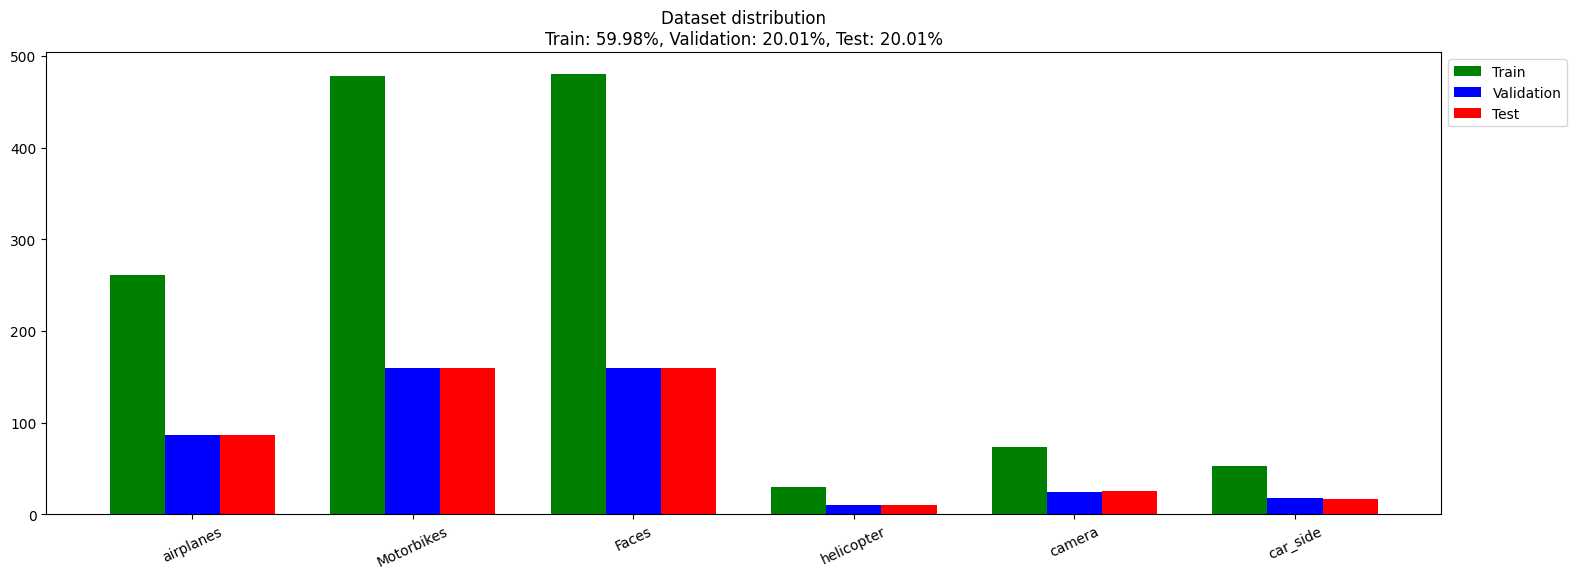

In [ ]:
plot_class_distribution(train_df,
                        val_df,
                        test_df,
                        class_names)

#### **Visualization**

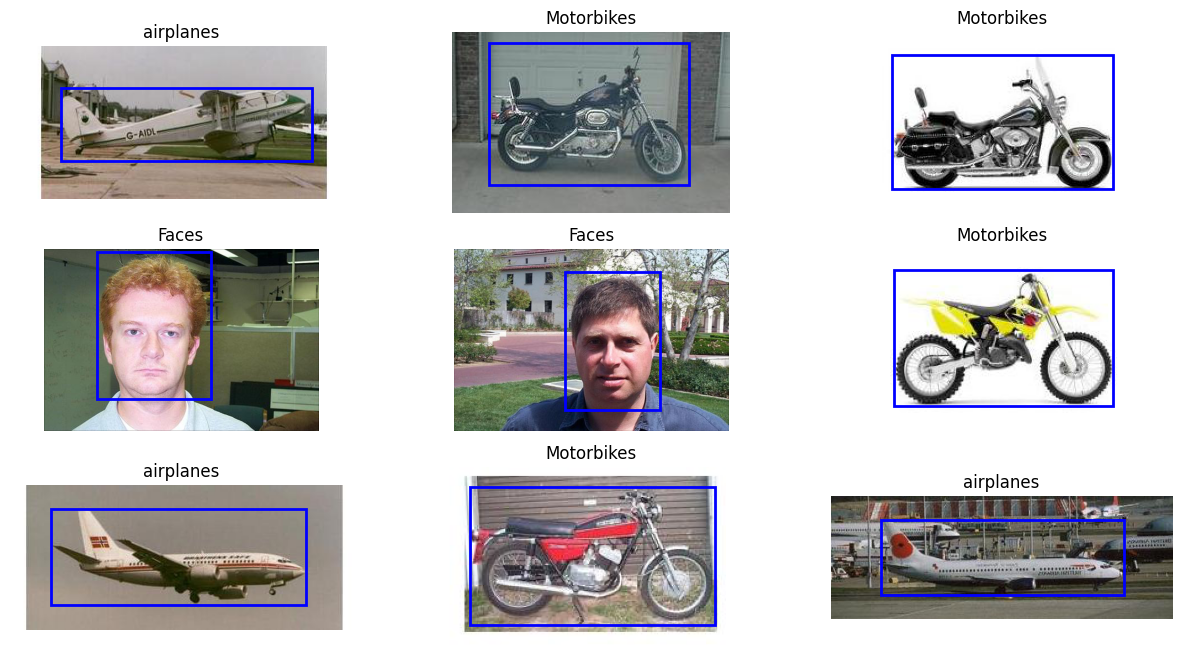

In [ ]:
show_samples_multiclass(df=df,
                        seed=SEED)

#### **Data Generator**

In [ ]:
train_data_gen = DataGenerator(path_images=train_df['path_image'].values,
                               labels=train_df['class_int'].values,
                               BBoxes=train_df['BBox'].values,
                               n_classes=n_classes,
                               batch_size=BATCH_SIZE,
                               target_size=[TARGET_SIZE[0],TARGET_SIZE[0],3],
                               preprocess_input=preprocess_inputs,
                               shuffle=True)

val_data_gen = DataGenerator(path_images=val_df['path_image'].values,
                             labels=val_df['class_int'].values,
                             BBoxes=val_df['BBox'].values,
                             n_classes=n_classes,
                             batch_size=BATCH_SIZE,
                             target_size=[TARGET_SIZE[0],TARGET_SIZE[0],3],
                             preprocess_input=preprocess_inputs,
                             shuffle=False)

For sanity check, let's see the data generator's output

In [ ]:
for x,y in train_data_gen:
    print(x.shape, y["label"].shape, y["BBox"].shape)
    break

(32, 224, 224, 3) (32, 6, 1) (32, 4)


### **Model**

In [ ]:
# define a dictionary to set the loss methods
losses = {
    "label": "categorical_crossentropy",#for the class label head
    "BBox": "mean_squared_error"#for the bounding box head
    }

# define a dictionary that specifies the weights per loss
lossWeights = {
    "label": 1.0,
    "BBox": 1.0
    }

multiclass_model = vgg16_multiclass(n_classes=n_classes,
                                    input_shape=(TARGET_SIZE[0],TARGET_SIZE[0],3),
                                    losses=losses,
                                    lossWeights=lossWeights)

In [ ]:
multiclass_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

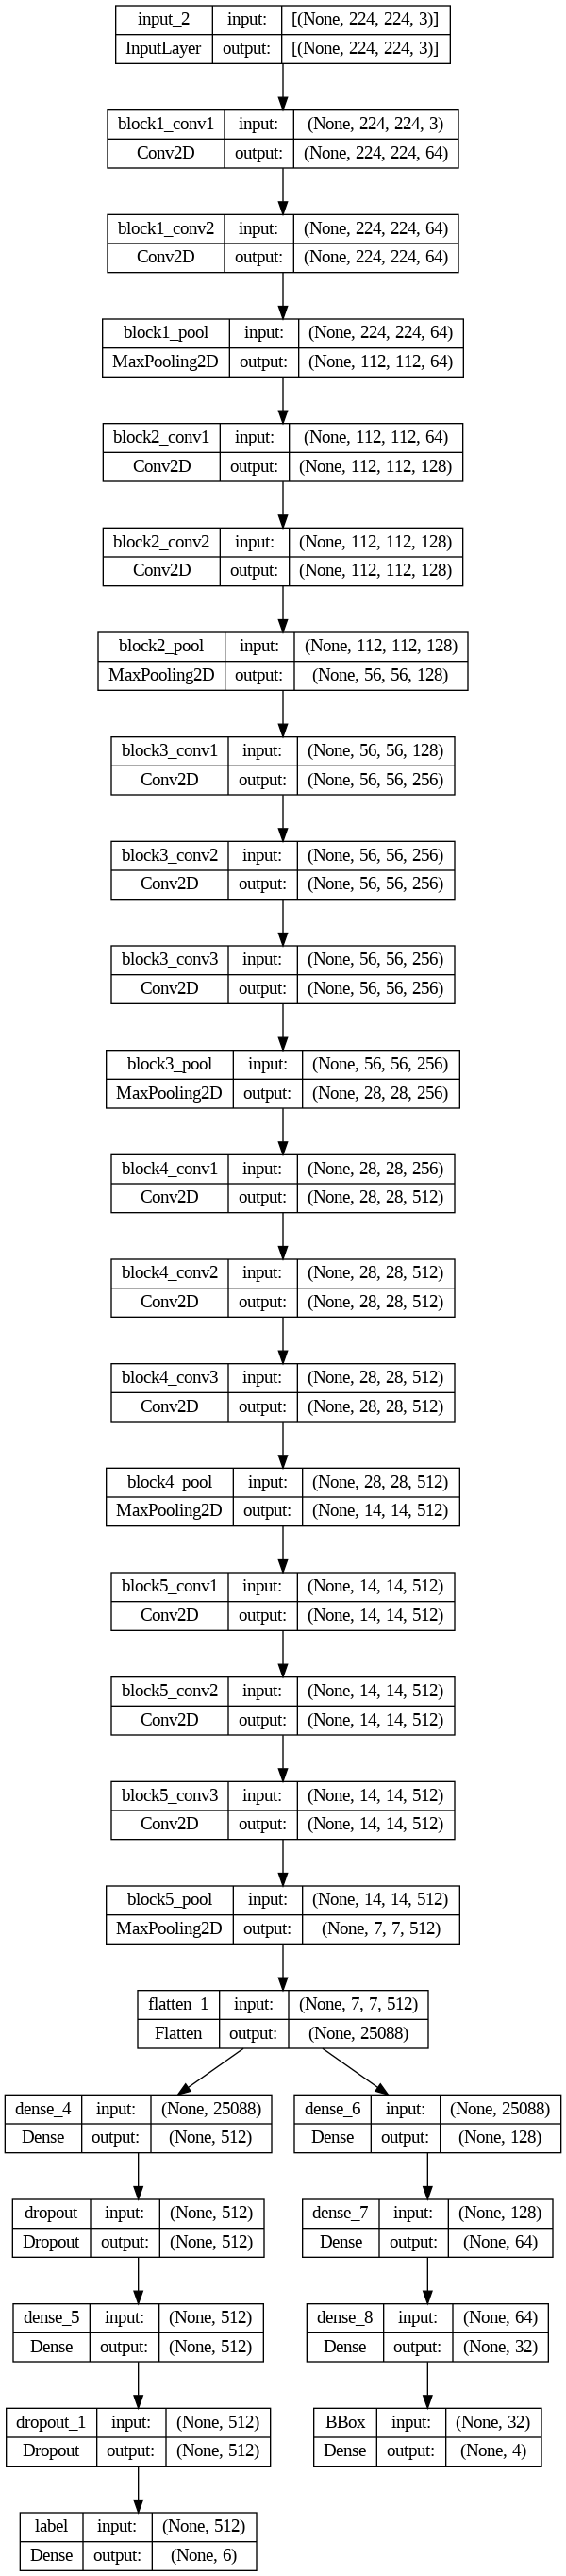

In [ ]:
plot_model(multiclass_model,
           to_file=join(MULTI_CLASS_DIR,"multiclass_model.png"),
           show_shapes=True)

#### **Callbacks**

In [ ]:
# Checkpoints
autosave_mc = ModelCheckpoint(join(MULTI_CLASS_DIR,"vgg16_multiclass.h5"),
                              mode="min",
                              save_best_only=True,
                              monitor="val_loss",
                              verbose=1)

# Early stopping
early_stop_mc = EarlyStopping(patience=20,
                              verbose=1,
                              mode="min",
                              monitor="val_loss",
                              restore_best_weights=True)

# Tensorboard
logdir_mc = join(PROJECT_DIR, "logs_multi_class")
tb_mc = TensorBoard(logdir_mc, histogram_freq=1)

cbks_mc = [autosave_mc, early_stop_mc, tb_mc]

#### **Training**

In [ ]:
history_mc = multiclass_model.fit(train_data_gen,
                                  validation_data=val_data_gen,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  callbacks=cbks_mc)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.6285 - label_loss: 0.6187 - BBox_loss: 0.0098 - label_accuracy: 0.8067 - BBox_accuracy: 0.7485
Epoch 1: val_loss improved from inf to 0.12431, saving model to ./multi_class/vgg16_multiclass.h5
43/43 [==============================] - 21s 398ms/step - loss: 0.6285 - label_loss: 0.6187 - BBox_loss: 0.0098 - label_accuracy: 0.8067 - BBox_accuracy: 0.7485 - val_loss: 0.1243 - val_label_loss: 0.1221 - val_BBox_loss: 0.0022 - val_label_accuracy: 0.9542 - val_BBox_accuracy: 0.8192
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.1227 - label_loss: 0.1211 - BBox_loss: 0.0017 - label_accuracy: 0.9673 - BBox_accuracy: 0.8634
Epoch 2: val_loss improved from 0.12431 to 0.04315, saving model to ./multi_class/vgg16_multiclass.h5
43/43 [==============================] - 18s 420ms/step - loss: 0.1227 - label_loss: 0.1211 - BBox_loss: 0.0017 - label_accuracy: 0.9673 - BBox_accuracy: 0.8634 - val_loss: 0.0431 - 

#### **TensorBoard Dev**

In [ ]:
!tensorboard dev upload --logdir logs_multi_class --name "Multi class object detection" --one_shot

2023-07-09 15:41:51.151525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/IxXdYEaESlav67mQMMKTDQ/

[2023-07-09T15:41:53] Started scanning logdir.
[2023-07-09T15:41:57] Total uploaded: 510 scalars, 1360 tensors (976.9 kB), 1 binary objects (172.6 kB)
[2023-07-09T15:41:57] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/IxXdYEaESlav67mQMMKTDQ/


### **Results**

In [ ]:
multiclass_model = load_model(join(MULTI_CLASS_DIR,"vgg16_multiclass.h5"))

In [ ]:
test_data_gen = DataGenerator(path_images=test_df['path_image'].values,
                              labels=test_df['class_int'].values,
                              BBoxes=test_df['BBox'].values,
                              n_classes=n_classes,
                              batch_size=BATCH_SIZE,
                              target_size=[TARGET_SIZE[0],TARGET_SIZE[0],3],
                              preprocess_input=preprocess_inputs,
                              shuffle=False)

In [ ]:
scores = multiclass_model.evaluate(test_data_gen)
_,test_BBox_loss,test_class_loss, test_label_accuracy, test_BBox_accuracy = scores
print(f"\ntest set :\n \tLabel accuracy:{test_label_accuracy:.4f}\n\tBBox accuracy: {test_BBox_accuracy:.4f}")

15/15 [==============================] - 3s 194ms/step - loss: 0.0107 - label_loss: 0.0096 - BBox_loss: 0.0011 - label_accuracy: 0.9978 - BBox_accuracy: 0.8715

test set :
 	Label accuracy:0.9978
	BBox accuracy: 0.8715


In [ ]:
n_images = 9
rng = np.random.default_rng(SEED)
selected_idx = rng.integers(test_df.shape[0], size=n_images)
selected_images_path = test_df['path_image'].values[selected_idx]
selected_labels = test_df['class_int'].values[selected_idx]
selected_BBox = test_df['BBox'].values[selected_idx]

print(f"Selected images: {selected_idx}")
(labelPreds,predicted_BBoxes) = multiclass_model.predict(test_data_gen)
predicted_labels = np.argmax(labelPreds,axis=1)

Selected images: [ 40 355 300 201 198 394  39 320  92]
15/15 [==============================] - 3s 176ms/step


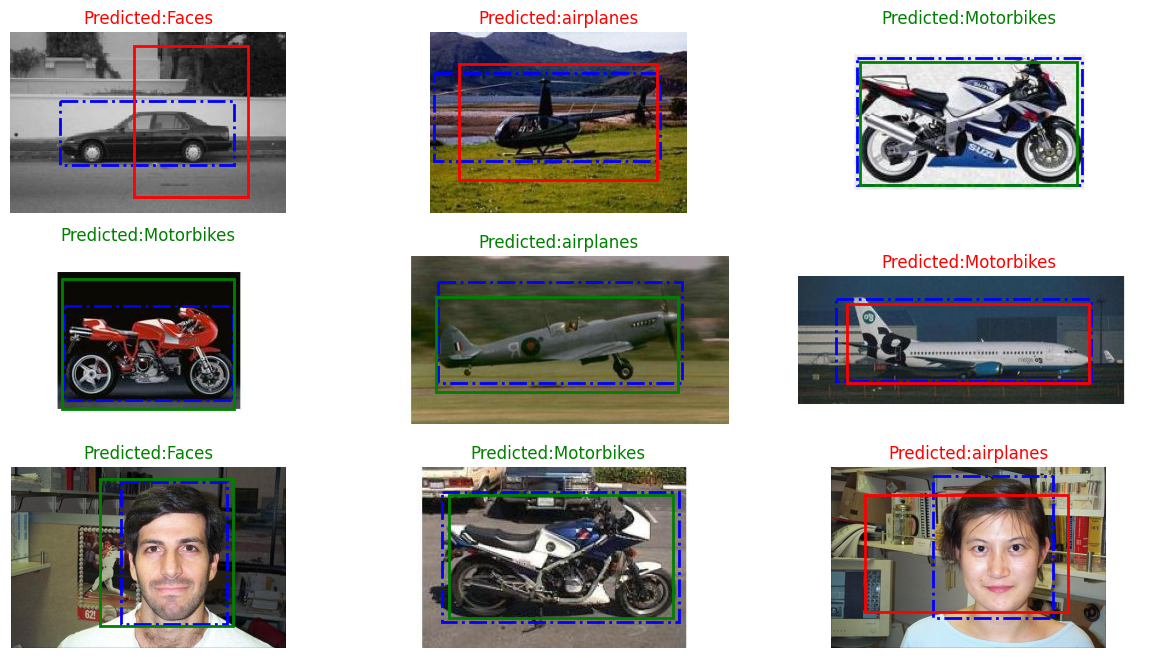

In [ ]:
show_results_multiclass(selected_idx=selected_idx,
                        selected_images_path=selected_images_path,
                        selected_labels=selected_labels,
                        selected_BBox=selected_BBox,
                        predicted_labels=predicted_labels,
                        predicted_BBoxes=predicted_BBoxes,
                        class_names=class_names)